# TankPressureCalc
Расчет изменения давления, массового расхода и скорости бака при истечении воздуха через отверстие. Построение графиков и вывод значений, полученных в результате расчета.

## Условие задачи:
1. Имеется толстостенный цилиндрический бак с объемом 1 м3, заполненный воздухом с давлением 200 атм. В баке просверливают отверстие ø5 мм. Необходимо построить график изменения давления внутри бака от времени. Также построить график массового расхода воздуха через отверстие от времени.
2. Бак изначально располагается в условиях невесомости в космосе. До появления отверстия бак находился в состоянии покоя относительно системы координат. Необходимо построить график изменения его скорости от времени в процессе истечения воздуха из просверленного отверстия. Геометрию и массу бака и задать произвольно, ось отверстия проходит через центр масс бака.

## Решение:
Решение приведено в формате Jupyter Notebook "main.ipynb" для удобного запуска в облачных системах типа Google Colab или на персональных компьютерах. Для запуска кода блокнота Jupyter Notebook в облачной системе Google Colab нужно перейти по ссылке:

https://colab.research.google.com/github/mikiway902/TankPressureCalc/blob/main/main.ipynb

В файле кода языка python "MainCode.py" содержащем код программы.

Код выполнен с использованием основных библиотек  **math**, **numpy**, **matplotlib**.

Библиотека math была использована для добавления в python математической функции "**корень числа**"

Библиотека mathplotlib была использована для создания и сохранения графиков по полученным в результате расчета значениям в формате PNG.

Библиотека numpy была использована для проведения математических операций с массивами. Позволяет вычислять производить вычисления со всеми значениями сразу, а не через цикл.

Так же были использованы второстепенные библиотеки для автоматической установки зависимостей (библиотек): **importlib**, **subprocess**, **sys**.

Все данные, полученные в результате вычислений, сохраняются в папку **Results**.

## 🟦 Площадь отверстия

$$
F = \frac{\pi d^2}{4}
$$

где \( d \) — диаметр отверстия в метрах.

---

## 🟧 Критическое отношение давлений

$$
\sigma_{\text{кр}} = \left( \frac{2}{k + 1} \right)^{\frac{k}{k - 1}}
$$

Это значение определяет, при каком соотношении давлений истечение становится **переходным**.

---

## 🟨 Функция режима истечения

Если 
$$
\left ( \sigma_{} = \frac{p_2}{p_1} \right) > \sigma_{\text{кр}}
$$
, то:

$$
\varphi = \sqrt{ \sigma^{2/k} - \sigma^{(k+1)/k} }
$$

иначе (сверхзвуковой режим):

$$
\varphi = \sqrt{ \sigma_{\text{кр}}^{2/k} - \sigma_{\text{кр}}^{(k+1)/k} }
$$

---

## 🟥 Массовый расход газа (через отверстие)

$$
G_m = \sqrt{ \frac{2 k g}{k - 1} } \cdot \frac{F \cdot p_1 \cdot \varphi}{\sqrt{R T}}
$$

где:
- \( g \) — ускорение свободного падения
- \( \varphi \) — функция от отношения давлений
- \( F \) — площадь отверстия
- \( p_1 \) — внутреннее давление

---

## 🟩 Давление в сосуде с течением времени

$$
p_{i+1} = p_i - \frac{G_m \cdot k R T}{V_1} \cdot t
$$

(аппроксимация — убыль давления из-за утечки газа)

---


In [17]:
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

for pkg in ["matplotlib", "numpy"]:
    install_if_missing(pkg)

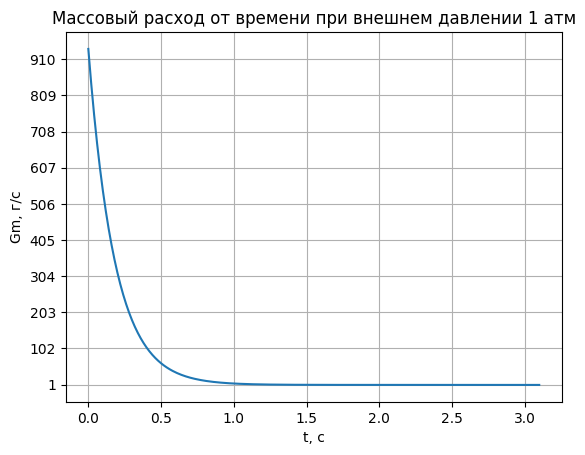

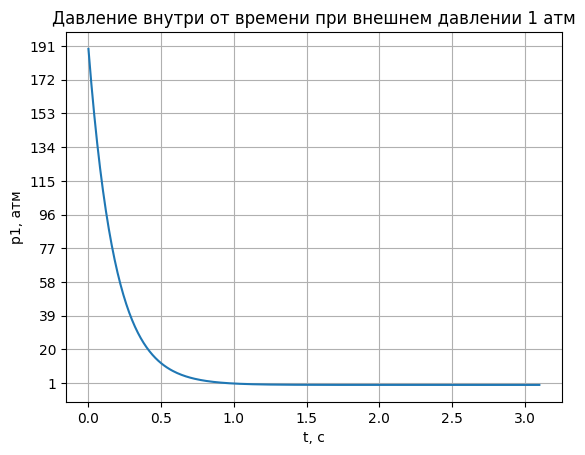

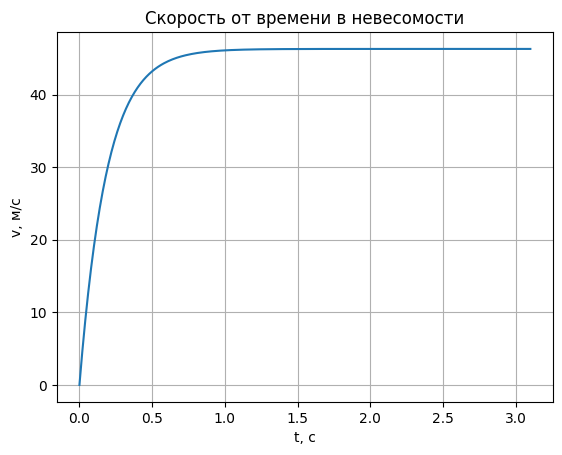

In [18]:
from math import sqrt  # Импорт функции квадратного корня
import matplotlib.pyplot as plt  # Импорт библиотеки для построения графиков
import numpy as np     # Для векторных операций
import os

def main():
    # Создание папки Results, если её нет
    results_dir = "Results"
    os.makedirs(results_dir, exist_ok=True)

    # Исходные параметры
    g = 9.807               # Ускорение свободного падения (м/с²)
    R = 29.27               # Газовая постоянная для конкретного газа (Дж/(кг·К))
    T = 280                 # Температура газа (К)
    k = 1.4                 # Адиабатический показатель (Cp/Cv)
    V1 = 1                  # Объём сосуда (м³)
    p1 = 200                # Начальное давление (атм)
    p2_2 = 1                # Конечное давление (атм) для 2 задачи
    p2 = 1e-5               # Конечное давление (атм) для 3 задачи
    d = 5                   # Диаметр отверстия (см)
    pi = 3.14               # Приближённое значение числа π
    M = 0.029                  # Молярная масса газа (г/моль)
    mass_metal = 10**3      # Масса конструкции (кг)

    # Списки для хранения результатов
    list_Gm = []     # Список массового расхода
    list_p1 = []     # Список давлений внутри сосуда
    list_t = []      # Список времени

    # Преобразование единиц
    d = d * (10**(-2))                  # Перевод диаметра из см в м
    p1 = p1 * 0.101 * (10**6)           # Перевод давления p1 из атм в Па
    p2 = p2 * 0.101 * (10**6)           # Перевод давления p2 из атм в Па

    # Площадь отверстия (м²)
    F = (pi * (d**2)) / 4

    # Критическое отношение давления (для расчёта массового расхода)
    sig_krit = (2 / (k + 1))**(k / (k - 1))

    t = 0  # Начальное время
    delta_t = 0.01
    # Цикл выполняется, пока давление внутри (p1) выше давления снаружи (p2)
    while p1 > p2:
        sig = p2 / p1  # Отношение давлений

        # Расчёт функции φ (phi), зависящей от режима истечения (дозвуковой/звуковой)
        if sig > sig_krit:
            phi = sqrt(sig**(2/k) - sig**((k+1)/k))
        else:
            phi = sqrt(sig_krit**(2/k) - sig_krit**((k+1)/k))

        # Расчёт массового расхода (Gm)
        Gm = sqrt((2 * k * g) / (k - 1)) * ((F * p1 * phi) / (sqrt(R * T)))

        # Обновление давления p1 с учётом ушедшего газа
        p1 = p1 - Gm * k * R * T / V1 * delta_t *10

        # Сохранение значений в списки
        list_Gm.append(Gm)
        list_p1.append(p1)
        list_t.append(t)
        if p1 <= p2_2 * 0.101 * (10**6):     # Делаем срез по давлению для 2 задачи
            list_Gm_p2_2 = list_Gm
            list_p1_p2_2 = list_p1
            list_t_p2_2 = list_t
        # Инкремент времени (шаг 0.01 сек)
        t += delta_t

    # --- Переводим в numpy-массивы ---
    t_array = np.array(list_t)
    p1_array = np.array(list_p1)
    Gm_array = np.array(list_Gm)
    list_p1_p2_2_array = np.array(list_p1_p2_2)

    # Начальная плотность газа (кг/м³), исходя из уравнения состояния
    ro_0 = p1 * M / (R * T)

    # Начальная масса всей системы: газ + конструкция
    mass_0 = ro_0 * V1 + mass_metal

    # --- Векторные вычисления ---
    ro_array = p1_array * M / (R * T)               # Плотность
    v_e_array = Gm_array / (ro_array * F) / 10          # Скорость истечения
    mass_f_array = mass_0 - ((ro_0 - ro_array) * V1)  # Масса системы
    v_array = v_e_array * np.log(mass_0 / mass_f_array)  # Формула Циолковского
    list_p1_p2_2_array = list_p1_p2_2_array / (0.101 * (10**6))  # Перевод давления в атм

    idx = np.argmax(v_array)
    v_array = v_array[:idx+1]
    v_array = v_array + abs(v_array[0])  # Начальная скорость

    # --- Сохраняем график массового расхода ---
    plt.figure()
    plt.grid(True)
    plt.plot(list_t_p2_2, list_Gm_p2_2)
    plt.title('Массовый расход от времени при внешнем давлении 1 атм')
    plt.xlabel('t, c')
    plt.ylabel('Gm, г/c')
    y_min = 1
    y_max = int(max(list_Gm)) + 1
    plt.yticks(np.arange(y_min, y_max, step=101))
    plt.savefig(os.path.join(results_dir, "mass_flow_vs_time.png"), dpi=600)
    plt.show()
    plt.close()

    # --- Сохраняем график давления ---
    plt.figure()
    plt.grid(True)
    plt.plot(list_t_p2_2, list_p1_p2_2_array)
    plt.title('Давление внутри от времени при внешнем давлении 1 атм')
    plt.xlabel('t, c')
    plt.ylabel('p1, атм')
    y_min = 1
    y_max = int(max(np.array(list_p1)/1e5)) + 1
    plt.yticks(np.arange(y_min, y_max, step=19))
    plt.savefig(os.path.join(results_dir, "pressure_vs_time.png"), dpi=600)
    plt.show()
    plt.close()

    # --- Сохраняем график скорости ---
    plt.figure()
    plt.grid(True)
    plt.plot(t_array, v_array)
    plt.title('Скорость от времени в невесомости')
    plt.xlabel('t, с')
    plt.ylabel('v, м/с')
    plt.savefig(os.path.join(results_dir, "velocity_vs_time.png"), dpi=600)
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()